In [58]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

from pyproj import CRS, Transformer

MAPS_ENABLED = False

data_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"

# download data
if not os.path.isfile("data.csv"):
    urllib.request.urlretrieve(data_url, "data.csv")

"""
Use the store_object function to make local caching of the data.
"""
def store_object(filename, instruction):
    # check if file was cached before and read it
    if os.path.isfile(filename):
        return pickle.load(open(filename, 'rb'))
    # run instruction and save it as pickle then return object
    else:
        obj = instruction()
        pickle.dump(obj, open(filename, 'wb'))
        return obj
    
data = store_object("data.pkl", lambda: pd.read_csv("data.csv"))

In [59]:
data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


In [60]:
data.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

### Cleaning data

In [61]:
# find missing values
missing_values = data.isnull().sum()
missing_values

DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd                 0
Crm Cd Desc            0
Mocodes           131889
Vict Age               0
Vict Sex          125454
Vict Descent      125464
Premis Cd             10
Premis Desc          563
Weapon Used Cd    615391
Weapon Desc       615391
Status                 0
Status Desc            0
Crm Cd 1              11
Crm Cd 2          870521
Crm Cd 3          936181
Crm Cd 4          938392
LOCATION               0
Cross Street      791589
LAT                    0
LON                    0
dtype: int64

In [62]:
# print((data['Vict Age'] < 0).sum()) # There are 89 records with negative age - removing it
data = data[data["Vict Age"] >= 0]

In [63]:
# create 'DATE OCC' column to be merged DATE and TIME OCC - DATE represents the date of the incident and TIME OCC represents the time of the incident
data["DATE OCC"] = pd.to_datetime(data["DATE OCC"], format="%m/%d/%Y %I:%M:%S %p")
data["TIME OCC"] = pd.to_datetime(data["TIME OCC"].astype(str).str.zfill(4), format='%H%M')
data["DATE OCC"] = data["DATE OCC"].dt.date.astype(str) + " " + data["TIME OCC"].dt.time.astype(str)
data["DATE OCC"] = pd.to_datetime(data["DATE OCC"])

# drop 'TIME OCC' column
data = data.drop(columns=["TIME OCC"])

# drop everything after 2024/01/01 as data is incomplete
data = data[data["DATE OCC"] < "2024-01-01"]

### Data expansion

In [64]:
police_stations_data = pd.read_csv("lapd_stations.csv")
police_stations_data.head()

input_epsg = CRS("EPSG:2229") # NAD83
output_epsg = CRS("EPSG:4326") # WGS 84

# convert coordinates ["X"] and ["Y"] to Latitude and Longitude in police_stations_data
transformer = Transformer.from_crs(input_epsg, output_epsg, always_xy=True)
police_stations_data["LAT"], police_stations_data["LON"] = transformer.transform(police_stations_data["X"].values, police_stations_data["Y"].values)

# drop ["X"], ["Y"], ["OBJECTID"] columns
police_stations_data = police_stations_data.drop(columns=["X", "Y", "OBJECTID"])

# move colum "PREC" to be first
police_stations_data = police_stations_data[["PREC", "DIVISION", "LOCATION", "LAT", "LON"]].sort_values(by="PREC")

police_stations_data.head()


,PREC,DIVISION,LOCATION,LAT,LON
6,1,CENTRAL,251 E. 6TH ST.,-118.247282,34.044012
11,2,RAMPART,1401 W. 6TH ST.,-118.266967,34.056683
4,3,SOUTHWEST,1546 MARTIN LUTHER KING JR. BLVD.,-118.305130,34.010568
8,4,HOLLENBECK,2111 E. 1ST ST.,-118.213056,34.045001
0,5,HARBOR,2175 JOHN S. GIBSON BLVD.,-118.289231,33.757656


### Data mining

In [65]:
# maps common

popup_name_neighborhoods = folium.GeoJsonPopup(fields=["name"], labels=True)
geojson_neighborhoods = folium.GeoJson(
    "la_neighborhoods.geojson",
    style_function=lambda feature: {
        "fillColor": "#abcbff",
        "color": "black",
        "weight": 1,
        "dashArray": "3, 3",
    },
    highlight_function=lambda x: {"fillColor": "#458cff"},
    smooth_factor=2.0,
    name="LA neighborhoods",
    popup=popup_name_neighborhoods,
    zoom_on_click=True
)

# use alias that map PREC number to police station name using police_stations
popup_name_districts = folium.GeoJsonPopup(fields=["APREC"], labels=True)
geojson_districts = folium.GeoJson(
    "lapd_districts.geojson",
    style_function=lambda feature: {
        "fillColor": "#abcbff",
        "color": "black",
        "weight": 1,
        "dashArray": "3, 3",
    },
    highlight_function=lambda x: {"fillColor": "#458cff"},
    smooth_factor=2.0,
    name="LA districts",
    popup=popup_name_districts,
    zoom_on_click=True
)

In [66]:
# Some statistics about victims age depends on sex
data[data["Vict Sex"] == "M"]["Vict Age"].describe()

count    360086.000000
mean         37.481246
std          18.484113
min           0.000000
25%          27.000000
50%          36.000000
75%          50.000000
max          99.000000
Name: Vict Age, dtype: float64

In [67]:
data[data["Vict Sex"] == "F"]["Vict Age"].describe()

count    321733.000000
mean         38.292510
std          16.082866
min           0.000000
25%          27.000000
50%          35.000000
75%          48.000000
max          99.000000
Name: Vict Age, dtype: float64

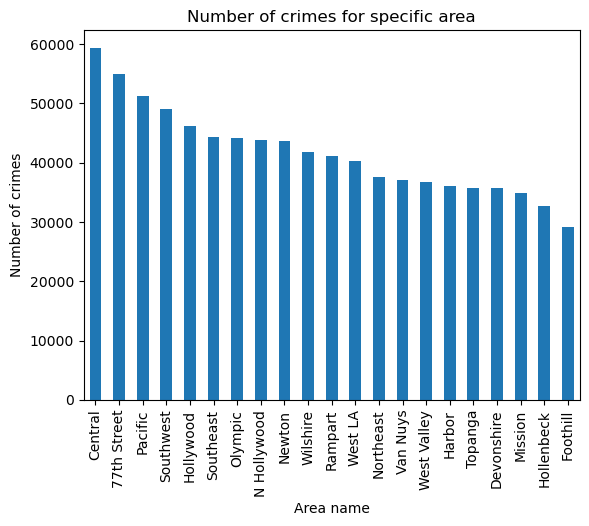

In [68]:
data["AREA NAME"].value_counts().plot(kind="bar")
plt.title("Number of crimes for specific area")
plt.xlabel("Area name")
plt.ylabel("Number of crimes")
plt.show()

In [69]:
# global heatmap of crimes

map = None
if MAPS_ENABLED:
    map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")
    geojson_neighborhoods.add_to(map)

    heat_data = data[["LAT", "LON"]]

    HeatMap(heat_data,
        gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
        min_opacity=0.05, 
        max_opacity=0.9, 
        radius=25,
        use_local_extrema=False  
    ).add_to(map)

map

In [70]:
# map of police stations and districts with crime count

map = None
if MAPS_ENABLED:
    map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")


    colormap = folium.LinearColormap(
        colors=["green", "yellow", "orange", "red"],
        vmin=data["AREA"].value_counts().min(),
        vmax=data["AREA"].value_counts().max(),
        caption="Number of crimes",
    )
    colormap.add_to(map)

    geojson_crimes = folium.GeoJson(
        "lapd_districts.geojson",
        style_function=lambda feature: {
            "fillColor": colormap(data["AREA"].value_counts().get(feature["properties"]["PREC"], 0)),
            "color": "black",
            "weight": 1,
            "dashArray": "3, 3",
        },
        smooth_factor=2.0,
        popup=folium.GeoJsonPopup(fields=["APREC"], labels=True)
    )
    geojson_crimes.add_to(map)

    for index, row in police_stations_data.iterrows():
        folium.Marker([row["LON"], row["LAT"]], popup=row["LOCATION"]).add_to(map)

map

In [71]:
print("Most popular crime:\n", data["Crm Cd"].value_counts()[:5])
# Here we can see that the most common crime is stealing vehicle.

Most popular crime:
 Crm Cd
510    93618
624    69420
354    55414
330    53955
310    53393
Name: count, dtype: int64


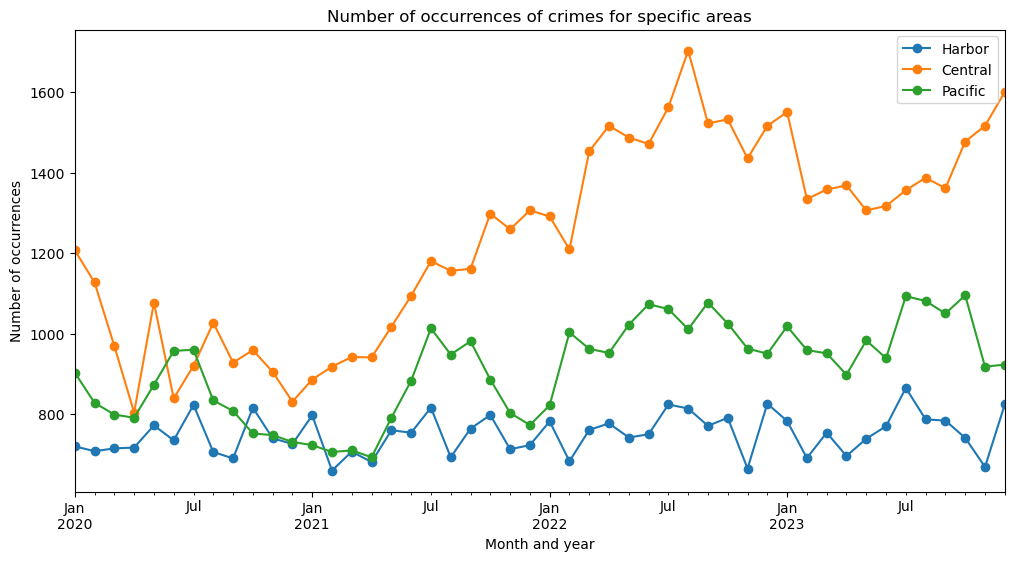

In [72]:
d1 = data[data["AREA NAME"] == "Harbor"]
d2 = data[data["AREA NAME"] == "Central"]
d3 = data[data["AREA NAME"] == "Newton"]
# Grupujemy dane według miesiąca i roku oraz zliczamy liczbę wystąpień przestępstw
count_by_month_year1 = d1.groupby(data["DATE OCC"].dt.to_period("M")).size()
count_by_month_year2 = d2.groupby(data["DATE OCC"].dt.to_period("M")).size()
count_by_month_year3 = d3.groupby(data["DATE OCC"].dt.to_period("M")).size()

count_by_month_year1.plot(marker="o", linestyle="-", figsize=(12, 6), label="Harbor")
count_by_month_year2.plot(marker="o", linestyle="-", figsize=(12, 6), label="Central")
count_by_month_year3.plot(marker="o", linestyle="-", figsize=(12, 6), label="Pacific")

plt.title("Number of occurrences of crimes for specific areas")
plt.xlabel("Month and year")
plt.ylabel("Number of occurrences")
plt.legend()
plt.show()

In [73]:
# heat map of crimes over time by month

map = None
if MAPS_ENABLED:
    map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")
    geojson_neighborhoods.add_to(map)

    time_index = data["DATE OCC"].dt.to_period("M").unique()
    time_index = sorted(time_index)

    heat_data = data[['LAT', 'LON', 'DATE OCC']]
    heat_data = heat_data.groupby([heat_data['DATE OCC'].dt.to_period('M')])
    heat_data = [heat_data.get_group((x,)) for x in heat_data.groups]

    heat_data = [x[['LAT', 'LON']].values.tolist() for x in heat_data]

    HeatMapWithTime(heat_data, index=[str(x) for x in time_index],
        gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
        min_opacity=0.05, 
        max_opacity=0.9, 
        radius=25,
        use_local_extrema=False  
    ).add_to(map)
        

    for index, row in police_stations_data.iterrows():
        folium.Marker([row["LON"], row["LAT"]], popup=row["LOCATION"]).add_to(map)

map

In [74]:
# heat map of crimes over time by hour throughout whole time range of data

if MAPS_ENABLED:
    map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")
    geojson_neighborhoods.add_to(map)

    time_index = data["DATE OCC"].dt.to_period("h").unique()
    time_index = sorted(time_index)

    heat_data = data[['LAT', 'LON', 'DATE OCC']]
    heat_data = heat_data.groupby([heat_data['DATE OCC'].dt.to_period('h')])
    heat_data = [heat_data.get_group((x,)) for x in heat_data.groups]

    heat_data = [x[['LAT', 'LON']].values.tolist() for x in heat_data]

    HeatMapWithTime(heat_data, index=[str(x) for x in time_index],
        gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
        min_opacity=0.05, 
        max_opacity=0.9, 
        radius=25,
        use_local_extrema=False                
    ).add_to(map)

    for index, row in police_stations_data.iterrows():
        folium.Marker([row["LON"], row["LAT"]], popup=row["LOCATION"]).add_to(map)

map

In [75]:
# heat map of crimes that occured during night between 22:00 and 5:00

if MAPS_ENABLED:
    map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")
    geojson_neighborhoods.add_to(map)

    heat_data = data[['LAT', 'LON', 'DATE OCC']]
    heat_data = heat_data[(heat_data["DATE OCC"].dt.hour >= 22) | (heat_data["DATE OCC"].dt.hour < 5)]
    heat_data = heat_data[['LAT', 'LON']].values.tolist()

    HeatMap(heat_data,
        gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
        min_opacity=0.05, 
        max_opacity=0.9, 
        radius=25,
        use_local_extrema=False
    ).add_to(map)

    for index, row in police_stations_data.iterrows():
        folium.Marker([row["LON"], row["LAT"]], popup=row["LOCATION"]).add_to(map)

map

In [76]:
# heat map of crimes that occured during night between 5:00 and 22:00

if MAPS_ENABLED:
    map = folium.Map(location=[34.0522, -118.2437], zoom_start=10, tiles="CartoDB positron")
    geojson_neighborhoods.add_to(map)

    heat_data = data[['LAT', 'LON', 'DATE OCC']]
    heat_data = heat_data[(heat_data["DATE OCC"].dt.hour >= 5) & (heat_data["DATE OCC"].dt.hour < 22)]
    heat_data = heat_data[['LAT', 'LON']].values.tolist()

    HeatMap(heat_data,
        gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
        min_opacity=0.05, 
        max_opacity=0.9, 
        radius=25,
        use_local_extrema=False
    ).add_to(map)

    for index, row in police_stations_data.iterrows():
        folium.Marker([row["LON"], row["LAT"]], popup=row["LOCATION"]).add_to(map)

map

In [160]:
# median income vs crimes
median_income = pd.read_csv("median_income.csv")

crime_counts = data.groupby(['AREA NAME', 'Crm Cd Desc']).size().reset_index(name='Count')

crime_counts = crime_counts.sort_values(['AREA NAME', 'Count'], ascending=[True, False])

# Rank the crimes within each AREA NAME and filter to top 3
crime_counts['Rank'] = crime_counts.groupby('AREA NAME')['Count'].rank(method='first', ascending=False)
top_3_crimes = crime_counts[crime_counts['Rank'] <= 10].drop(columns=['Rank'])

merged_df = top_3_crimes.merge(median_income, left_on='AREA NAME', right_on='neighborhood', how='inner').drop(columns=['neighborhood'])

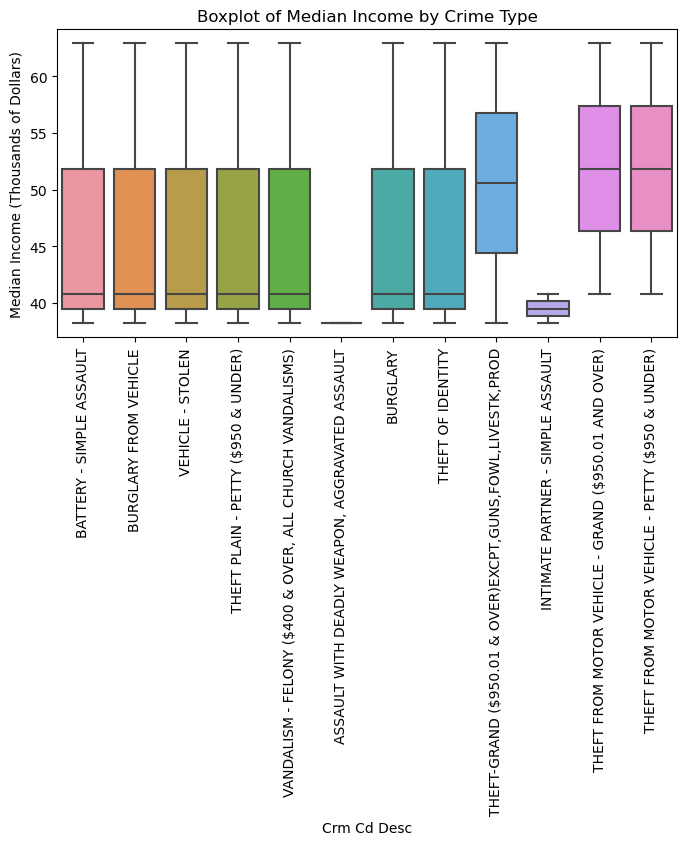

In [165]:
import seaborn as sns

summary_stats = merged_df.groupby('Crm Cd Desc')['med_income'].describe()

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='Crm Cd Desc', y='med_income', data=merged_df)
plt.ylabel('Median Income (Thousands of Dollars)')
plt.xticks(rotation=90)
plt.title('Boxplot of Median Income by Crime Type')
plt.show()